In [3]:
% matplotlib inline

import time
import pandas as pd

from IPython import display as d

import seaborn as sns
sns.set()

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import feature_selection as fs

from imblearn.under_sampling import RandomUnderSampler

from libs import container
from libs.experiment import (
    WithAnotherExperiment, KFoldExperiment, roc, 
    discretize_classes, clean_features)

In [4]:
data = container.Container(sample=pd.read_pickle("data/sample.pkl"))
data["balanced"] = pd.concat((
    data.sample[data.sample.nbg == 1].sample(786),
    data.sample[data.sample.nbg == 0]))
data["small_sample"] = pd.read_pickle("data/small_sample.pkl")

In [5]:
sclasses = {
    "nbg": 1,
    "no-nbg": 0}
sclasses

{'nbg': 1, 'no-nbg': 0}

In [6]:
data.sample.shape, data.balanced.shape, data.small_sample.shape

((12598, 161), (1572, 161), (4352, 161))

In [7]:
X_columns = clean_features(data, "sample")
X_columns = X_columns[
    ~(X_columns.str.contains("Freq2_") | X_columns.str.contains("Freq3_") | X_columns.str.contains("_cnt"))]
print("Total features:", X_columns.size)

Removing [] because null
Removing ['src1_Freq1_harmonics_rel_phase_0', 'src1_Freq2_harmonics_rel_phase_0', 'src1_Freq3_harmonics_rel_phase_0', 'src2_Freq1_harmonics_rel_phase_0', 'src2_Freq2_harmonics_rel_phase_0', 'src2_Freq3_harmonics_rel_phase_0'] because lowvariance
('Total features:', 112)


In [8]:
set(x.split("_", 1)[-1] for x in X_columns)

{'Amplitude',
 'AmplitudeH',
 'AmplitudeJ',
 'AmplitudeJH',
 'AmplitudeJK',
 'Autocor_length',
 'Beyond1Std',
 'CAR_mean',
 'CAR_sigma',
 'CAR_tau',
 'Con',
 'Eta_e',
 'FluxPercentileRatioMid20',
 'FluxPercentileRatioMid35',
 'FluxPercentileRatioMid50',
 'FluxPercentileRatioMid65',
 'FluxPercentileRatioMid80',
 'Freq1_harmonics_amplitude_0',
 'Freq1_harmonics_amplitude_1',
 'Freq1_harmonics_amplitude_2',
 'Freq1_harmonics_amplitude_3',
 'Freq1_harmonics_rel_phase_1',
 'Freq1_harmonics_rel_phase_2',
 'Freq1_harmonics_rel_phase_3',
 'Gskew',
 'LinearTrend',
 'MaxSlope',
 'Mean',
 'Meanvariance',
 'MedianAbsDev',
 'MedianBRP',
 'PairSlopeTrend',
 'PercentAmplitude',
 'PercentDifferenceFluxPercentile',
 'PeriodLS',
 'Period_fit',
 'Psi_CS',
 'Psi_eta',
 'Q31',
 'Rcs',
 'Skew',
 'SmallKurtosis',
 'Std',
 'c89_c3',
 'c89_hk_color',
 'c89_jh_color',
 'c89_jk_color',
 'c89_m2',
 'c89_m4',
 'n09_c3',
 'n09_hk_color',
 'n09_jh_color',
 'n09_jk_color',
 'n09_m2',
 'n09_m4',
 'ppmb'}

In [9]:
sample = "small_sample"

In [10]:
df = data[sample]
y = df["nbg"].values

skb = fs.SelectPercentile(percentile=10, score_func=fs.mutual_info_classif)
skb.fit(df[X_columns].values, y)

fX_columns = X_columns[skb.get_support()]

KNN
             precision    recall  f1-score   support

        0.0       0.11      0.51      0.18       253
        1.0       0.96      0.75      0.84      4099

avg / total       0.91      0.74      0.81      4352

--------------------------------------------------------------------------------
 
Flt. KNN
             precision    recall  f1-score   support

        0.0       0.11      0.60      0.18       253
        1.0       0.97      0.68      0.80      4099

avg / total       0.92      0.68      0.76      4352

--------------------------------------------------------------------------------
 
Random Forest
             precision    recall  f1-score   support

        0.0       0.62      0.78      0.69       786
        1.0       0.70      0.52      0.60       786

avg / total       0.66      0.65      0.64      1572

--------------------------------------------------------------------------------
 
Flt. Random Forest
             precision    recall  f1-score   support

      

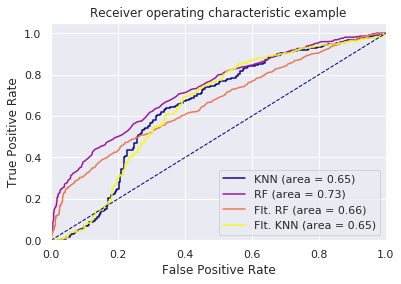

CPU times: user 6.12 s, sys: 3.92 s, total: 10 s
Wall time: 43.1 s


In [11]:
%%time
print "KNN"
knn = KFoldExperiment(
    clf=KNeighborsClassifier(n_neighbors=50, weights='distance'), 
    clsnum=sclasses, sampler=RandomUnderSampler(),
    data=data, pcls="nbg", ncls="no-nbg", X_columns=X_columns, y_column="nbg")(sample, nfolds=10)

print " "
print "Flt. KNN"
flt_knn = KFoldExperiment(
    clf=KNeighborsClassifier(n_neighbors=50, weights='distance'),
    clsnum=sclasses, sampler=RandomUnderSampler(),
    data=data, pcls="nbg", ncls="no-nbg", X_columns=fX_columns, y_column="nbg")(sample, nfolds=10)

print " "
print "Random Forest"
rf = KFoldExperiment(
    clf=RandomForestClassifier(n_estimators=500, criterion="entropy"), 
    sampler=RandomUnderSampler(),
    clsnum=sclasses, data=data, pcls="nbg", ncls="no-nbg", 
    X_columns=X_columns, y_column="nbg")("balanced", nfolds=10)

print " "
print "Flt. Random Forest"
flt_rf = KFoldExperiment(
    clf=RandomForestClassifier(n_estimators=500, criterion="entropy"), 
    sampler=RandomUnderSampler(),
    clsnum=sclasses, data=data, pcls="nbg", ncls="no-nbg", 
    X_columns=fX_columns, y_column="nbg")("balanced", nfolds=10)

roc({"KNN": knn, "RF": rf, "Flt. KNN": flt_knn, "Flt. RF": flt_rf})

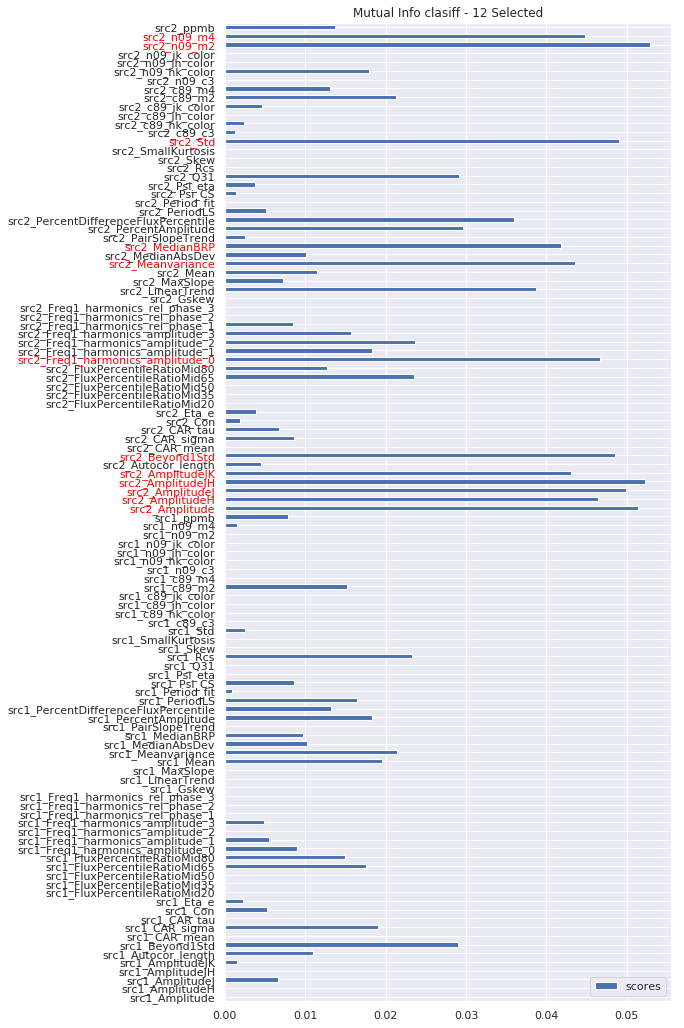

In [20]:
ax = pd.DataFrame(
        {"scores": skb.scores_}, index=X_columns).plot.barh(
    figsize=(8, 18))
ax.set_title("Mutual Info clasiff - {} Selected".format(
        skb.get_support().sum()))

for idx in skb.get_support(True):
    ax.get_yticklabels()[idx].set_color("red")